# Final Project
Clay Kindiger and Haoyang Pang

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,mean_squared_error, mean_absolute_error, r2_score

## Load Original Data

In [ ]:
players_team = pd.read_csv('full_player_stats.csv')
advanced_stats = pd.read_csv('data/advanced_players.csv')
mvp_voting = pd.read_csv('data/mvp_voting_shares.csv')
dpoy_voting = pd.read_csv('data/dpoy_voting.csv')

In [ ]:
players_team.head()

In [ ]:
advanced_stats.head()

In [ ]:
mvp_voting.head()

In [ ]:
dpoy_voting.head()

## Clean Data

In [ ]:
players_team.drop(columns = ['mvp','dpoy'],inplace = True)

In [ ]:
season = []
start = 2023
for idx,row in dpoy_voting.iterrows():
    if row['Rank'] == '1':
        start -= 1
    
    season.append(start)
dpoy_voting['Season'] = season

In [ ]:
dpoy_voting = dpoy_voting[['Season', 'Player',  'Pts Won', 'Pts Max', 'Share']]
dpoy_voting.head()

In [ ]:
advanced_stats = advanced_stats[advanced_stats['Player'] != 'Player']

In [ ]:
players_teams = {}
for ply,group in advanced_stats.groupby(['Player','Season']):
    if group.shape[0] > 1:
        tm = list(group.Tm)[-1]
        if 28 in group.index:
            print(group.Tm)
        players_teams[list(group.index)[0]] = tm
        if tm == 'TOT':
            print(ply)

In [ ]:
teams_list = []
for idx,row in advanced_stats.iterrows():
    if idx in players_teams.keys():
        tm = players_teams[idx]
        teams_list.append(tm)
    else:
        tm = row['Tm']
        if idx == 3613:
            tm = 'UTA'
        elif idx == 21:
            tm = 'MIA'
        elif idx == 4189:
            tm = 'WAS'
        elif idx == 3037:
            tm = 'BOS'
        elif idx == 11099:
            tm = 'CHI'
        elif idx == 6128:
            tm = 'NJN'
        teams_list.append(tm)
advanced_stats['Tm'] = teams_list

In [ ]:
advanced_stats.drop_duplicates(['Player','Season'],keep = 'first',inplace = True)

In [ ]:
players_team.shape

In [ ]:
advanced_stats.shape

In [ ]:
advanced_stats.columns

In [ ]:
players_team.columns

In [ ]:
advanced_stats = advanced_stats[['Season', 'Player', 'Tm', 'PER', 'TS%', '3PAr',
       'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']]

In [ ]:
full_players = players_team.merge(advanced_stats, on = ['Player','Tm','Season'],how = 'inner')
full_players.shape

In [ ]:
full_players.head()

In [ ]:
full_players_mvp = full_players.merge(mvp_voting,on = ['Season','Player'],how = 'left')
full_players_mvp.shape

In [ ]:
full_players_mvp

In [ ]:
full_players_mvp[~full_players_mvp['Share'].isnull()]

In [ ]:
full_players_awards = full_players_mvp.merge(dpoy_voting,on = ['Season','Player'],how = 'left',suffixes = ('_mvp','_dpoy'))
full_players_awards.shape

In [ ]:
full_players_awards.fillna(0,inplace = True)

In [ ]:
full_players_awards.to_csv('full_players_dataset.csv',index = False)

In [ ]:
full_dataset = pd.read_csv('full_players_dataset.csv')
full_dataset.head()

In [ ]:
full_dataset.columns

In [ ]:
full_dataset['received_mvp_votes'] = [1 if row['Share_mvp']!=0 else 0 for idx,row in full_dataset.iterrows()]
full_dataset['received_dpoy_votes'] = [1 if row['Share_dpoy']!=0 else 0 for idx,row in full_dataset.iterrows()]

In [ ]:
cols_to_normalize = ['G','GS','W','L','FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%']

In [ ]:
normalized = full_dataset.groupby('Season')[cols_to_normalize].transform(lambda x: (x - x.mean()) / x.std())

In [ ]:
full_normalized = full_dataset.merge(normalized,right_index = True,left_index=True,suffixes = ('','_normalized'))

In [ ]:
full_normalized.head()

In [ ]:
full_normalized.drop(cols_to_normalize,axis = 1,inplace=True)

In [ ]:
full_normalized.head()

In [ ]:
full_normalized.to_csv("normalized_data.csv",index=False)

## Load Cleaned Data

In [2]:
full_dataset = pd.read_csv('normalized_data.csv')
full_dataset.head()

,Season,Player,Pos,Age,Tm,MP,Year,Team,W/L%,GB,...,3PAr_normalized,FTr_normalized,ORB%_normalized,DRB%_normalized,TRB%_normalized,AST%_normalized,STL%_normalized,BLK%_normalized,TOV%_normalized,USG%_normalized
0,1998,Mahmoud Abdul-Rauf,PG,28.0,SAC,530.0,1998,SAC,0.329,34.0,...,-0.223145,-1.479163,-1.061591,-1.082926,-1.256266,0.678781,-0.270151,-0.824493,-1.271023,1.028959
1,1998,Tariq Abdul-Wahad,SG,23.0,SAC,959.0,1998,SAC,0.329,34.0,...,-0.577654,0.059612,-0.333466,-0.775932,-0.686891,-0.475951,0.010661,-0.352740,-0.260471,0.499256
2,1998,Terry Dehere,PG,26.0,SAC,1410.0,1998,SAC,0.329,34.0,...,0.817135,-0.627813,-0.984946,-1.050611,-1.195261,0.967465,0.010661,-0.765524,0.118486,-0.118731
3,1998,Lawrence Funderburke,PF,27.0,SAC,1094.0,1998,SAC,0.329,34.0,...,-0.781061,0.403325,0.241370,0.419729,0.370520,-0.358339,-0.925378,-0.352740,-0.513109,0.358002
4,1998,Derek Grimm,SF,23.0,SAC,34.0,1998,SAC,0.329,34.0,...,4.094891,-1.034981,-1.291525,-0.000368,-0.727560,-1.427536,2.537968,0.295920,0.188663,0.728794


## Feature Selection

In [3]:
full_dataset.columns

Index(['Season', 'Player', 'Pos', 'Age', 'Tm', 'MP', 'Year', 'Team', 'W/L%',
       'GB', 'PS/G', 'PA/G', 'SRS', 'Playoffs', 'Losing_season', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Pts Won_mvp',
       'Pts Max_mvp', 'Share_mvp', 'Pts Won_dpoy', 'Pts Max_dpoy',
       'Share_dpoy', 'received_mvp_votes', 'received_dpoy_votes',
       'G_normalized', 'GS_normalized', 'W_normalized', 'L_normalized',
       'FG_normalized', 'FGA_normalized', 'FG%_normalized', '3P_normalized',
       '3PA_normalized', '3P%_normalized', '2P_normalized', '2PA_normalized',
       '2P%_normalized', 'eFG%_normalized', 'FT_normalized', 'FTA_normalized',
       'FT%_normalized', 'ORB_normalized', 'DRB_normalized', 'TRB_normalized',
       'AST_normalized', 'STL_normalized', 'BLK_normalized', 'TOV_normalized',
       'PF_normalized', 'PTS_normalized', 'PER_normalized', 'TS%_normalized',
       '3PAr_normalized', 'FTr_normalized', 'ORB%_normalized',
       'DRB%_normalized', 'TRB%_normal

## Create Models

In [68]:
dpoy_dataset.shape

(11860, 23)

In [4]:
mvp_dataset = full_dataset[['Playoffs', 'OWS', 'DWS',
       'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'received_mvp_votes',
       'G_normalized', 'GS_normalized', 'W_normalized', 'L_normalized',
       'FG_normalized', 'FGA_normalized', 'FG%_normalized', '3P_normalized',
       '3PA_normalized', '3P%_normalized', '2P_normalized', '2PA_normalized',
       '2P%_normalized', 'eFG%_normalized', 'FT_normalized', 'FTA_normalized',
       'FT%_normalized', 'ORB_normalized', 'DRB_normalized', 'TRB_normalized',
       'AST_normalized', 'STL_normalized', 'BLK_normalized', 'TOV_normalized',
       'PF_normalized', 'PTS_normalized', 'PER_normalized', 'TS%_normalized',
       '3PAr_normalized', 'FTr_normalized', 'ORB%_normalized',
       'DRB%_normalized', 'TRB%_normalized', 'AST%_normalized',
       'STL%_normalized', 'BLK%_normalized', 'TOV%_normalized',
       'USG%_normalized']]

Xm = np.array(mvp_dataset.drop(['received_mvp_votes'],axis=1))
ym = np.array(mvp_dataset['received_mvp_votes'])

Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.1, random_state=42)

In [5]:
dpoy_dataset = full_dataset[['Playoffs', 'DWS',
       'WS', 'WS/48', 'DBPM', 'VORP', 'received_dpoy_votes',
       'G_normalized', 'GS_normalized', 'W_normalized', 'L_normalized',
       'ORB_normalized', 'DRB_normalized', 'TRB_normalized',
       'STL_normalized', 'BLK_normalized',
       'PF_normalized', 'PTS_normalized', 'PER_normalized',
       'DRB%_normalized', 'TRB%_normalized',
       'STL%_normalized', 'BLK%_normalized']]

Xd = np.array(dpoy_dataset.drop(['received_dpoy_votes'],axis=1))
yd = np.array(dpoy_dataset['received_dpoy_votes'])

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.1, random_state=42)

### Logistic Regression

#### MVP

In [6]:
mvp_logreg = LogisticRegression(max_iter=500).fit(Xm_train,ym_train)

#### DPOY

In [7]:
dpoy_logreg = LogisticRegression(max_iter=500).fit(Xd_train,yd_train)

### Random Forest

#### MVP

In [8]:
mvp_clf = RandomForestClassifier(30, oob_score = True).fit(Xm_train,ym_train)

#### DPOY

In [9]:
dpoy_clf = RandomForestClassifier(30, oob_score = True).fit(Xd_train,yd_train)

### Regression (predict vote share)

#### MVP

In [72]:
#create the new variable for the regression
ym_regr = np.array(full_dataset['Share_mvp'])

pred_votes = np.where(mvp_clf.predict(Xm) == 1)

Xm_pipe = Xm[pred_votes]
ym_pipe = ym_regr[pred_votes]

Xmp_train_regr, Xmp_test_regr, ymp_train_regr, ymp_test_regr = train_test_split(Xm_pipe, ym_pipe, test_size=0.2, random_state=42)

mvp_regr_pipe = RandomForestRegressor(n_estimators=50, oob_score=True).fit(Xmp_train_regr, ymp_train_regr)

mvp_regression_score = mvp_regr_pipe.score(Xmp_test_regr, ymp_test_regr)

In [73]:
#create the new variable for the regression
ym_regr = np.array(full_dataset['Share_mvp'])

Xmf_train_regr, Xmf_test_regr, ymf_train_regr, ymf_test_regr = train_test_split(Xm, ym_regr, test_size=0.2, random_state=42)

mvp_regr_full = RandomForestRegressor(n_estimators=50, oob_score=True).fit(Xmf_train_regr, ymf_train_regr)

mvp_regression_score = mvp_regr_full.score(Xmf_test_regr, ymf_test_regr)

#### DPOY

In [75]:
#create the new variable for the regression
yd_regr = np.array(full_dataset['Share_dpoy'])

pred_votes = np.where(dpoy_clf.predict(Xd) == 1)

Xd_pipe = Xd[pred_votes]
yd_pipe = yd_regr[pred_votes]

Xdp_train_regr, Xdp_test_regr, ydp_train_regr, ydp_test_regr = train_test_split(Xd_pipe, yd_pipe, test_size=0.2, random_state=42)

dpoy_regr_pipe = RandomForestRegressor(n_estimators=50, oob_score=True).fit(Xdp_train_regr, ydp_train_regr)

dpoy_regression_score = dpoy_regr_pipe.score(Xdp_test_regr, ydp_test_regr)

In [76]:
#create the new variable for the regression
yd_regr = np.array(full_dataset['Share_dpoy'])

Xdf_train_regr, Xdf_test_regr, ydf_train_regr, ydf_test_regr = train_test_split(Xd, yd_regr, test_size=0.2, random_state=42)

dpoy_regr_full = RandomForestRegressor(n_estimators=50, oob_score=True).fit(Xdf_train_regr, ydf_train_regr)

dpoy_regression_score = dpoy_regr_full.score(Xdf_test_regr, ydf_test_regr)

## Evaluate Models

### Logistic Regression

#### MVP

In [15]:
acc_mvp = accuracy_score(ym_test,mvp_logreg.predict(Xm_test))
print(f'The accuracy score was: {acc_mvp}')
print(confusion_matrix(ym_test,mvp_logreg.predict(Xm_test)))
print(f'F1 score = {f1_score(ym_test,mvp_logreg.predict(Xm_test))}')

The accuracy score was: 0.9890387858347386
[[1157    2]
 [  11   16]]
F1 score = 0.711111111111111


#### DPOY

In [16]:
acc_dpoy = accuracy_score(yd_test,dpoy_logreg.predict(Xd_test))
print(f'The accuracy score was: {acc_dpoy}')
print(confusion_matrix(yd_test,dpoy_logreg.predict(Xd_test)))
print(f'F1 score = {f1_score(yd_test,dpoy_logreg.predict(Xd_test))}')

The accuracy score was: 0.9688026981450253
[[1138    8]
 [  29   11]]
F1 score = 0.37288135593220345


### Random Forest

#### MVP

In [17]:
print(f'The training accuracy: {mvp_clf.score(Xm_train,ym_train)}')
print(f'The out of bag classification accuracy: {mvp_clf.oob_score_}')

The training accuracy: 0.9998126288176878
The out of bag classification accuracy: 0.9846355630504029


In [18]:
mvp_clf.score(Xm_test,ym_test)

0.9890387858347386

In [19]:
for i in range(20,100,5):
    mvp_clf = RandomForestClassifier(i, oob_score = True).fit(Xm_train,ym_train)
    print(f'Test Accuracy with {i} trees = {mvp_clf.score(Xm_test,ym_test)}')

/Users/claykindiger/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Test Accuracy with 20 trees = 0.9881956155143339
Test Accuracy with 25 trees = 0.9873524451939292
Test Accuracy with 30 trees = 0.9881956155143339
Test Accuracy with 35 trees = 0.9865092748735245
Test Accuracy with 40 trees = 0.9881956155143339
Test Accuracy with 45 trees = 0.9890387858347386
Test Accuracy with 50 trees = 0.9881956155143339
Test Accuracy with 55 trees = 0.9873524451939292
Test Accuracy with 60 trees = 0.9873524451939292
Test Accuracy with 65 trees = 0.9890387858347386
Test Accuracy with 70 trees = 0.9898819561551433
Test Accuracy with 75 trees = 0.9890387858347386
Test Accuracy with 80 trees = 0.9890387858347386
Test Accuracy with 85 trees = 0.9898819561551433
Test Accuracy with 90 trees = 0.9881956155143339
Test Accuracy with 95 trees = 0.9865092748735245


In [35]:
i = 0
feat_imp = {}
cols = list(mvp_dataset.columns)
for val in mvp_clf.feature_importances_:
    if cols[i] == 'received_mvp_votes':
        i += 1
        pass
    feat_imp[cols[i].split('_')[0]] = val
    print(f'The imporance of {cols[i]} = {val}')
    i += 1

The imporance of Playoffs = 0.004731850611507981
The imporance of OWS = 0.039814450513455155
The imporance of DWS = 0.02071104310867451
The imporance of WS = 0.0719187566153432
The imporance of WS/48 = 0.026726436978592078
The imporance of OBPM = 0.03851233460358196
The imporance of DBPM = 0.011846565314418668
The imporance of BPM = 0.06965740875110477
The imporance of VORP = 0.0877629967950283
The imporance of G_normalized = 0.008330496937919742
The imporance of GS_normalized = 0.011958561015633196
The imporance of W_normalized = 0.025730270784582877
The imporance of L_normalized = 0.029815547749258254
The imporance of FG_normalized = 0.0444927052639564
The imporance of FGA_normalized = 0.030428019224184307
The imporance of FG%_normalized = 0.007164347132285289
The imporance of 3P_normalized = 0.006293087262462971
The imporance of 3PA_normalized = 0.005895838223942739
The imporance of 3P%_normalized = 0.008197182972695392
The imporance of 2P_normalized = 0.043289042987129246
The impor

In [44]:
mvp_feat_imp = {k: v for k, v in sorted(feat_imp.items(), key=lambda item: item[1])}

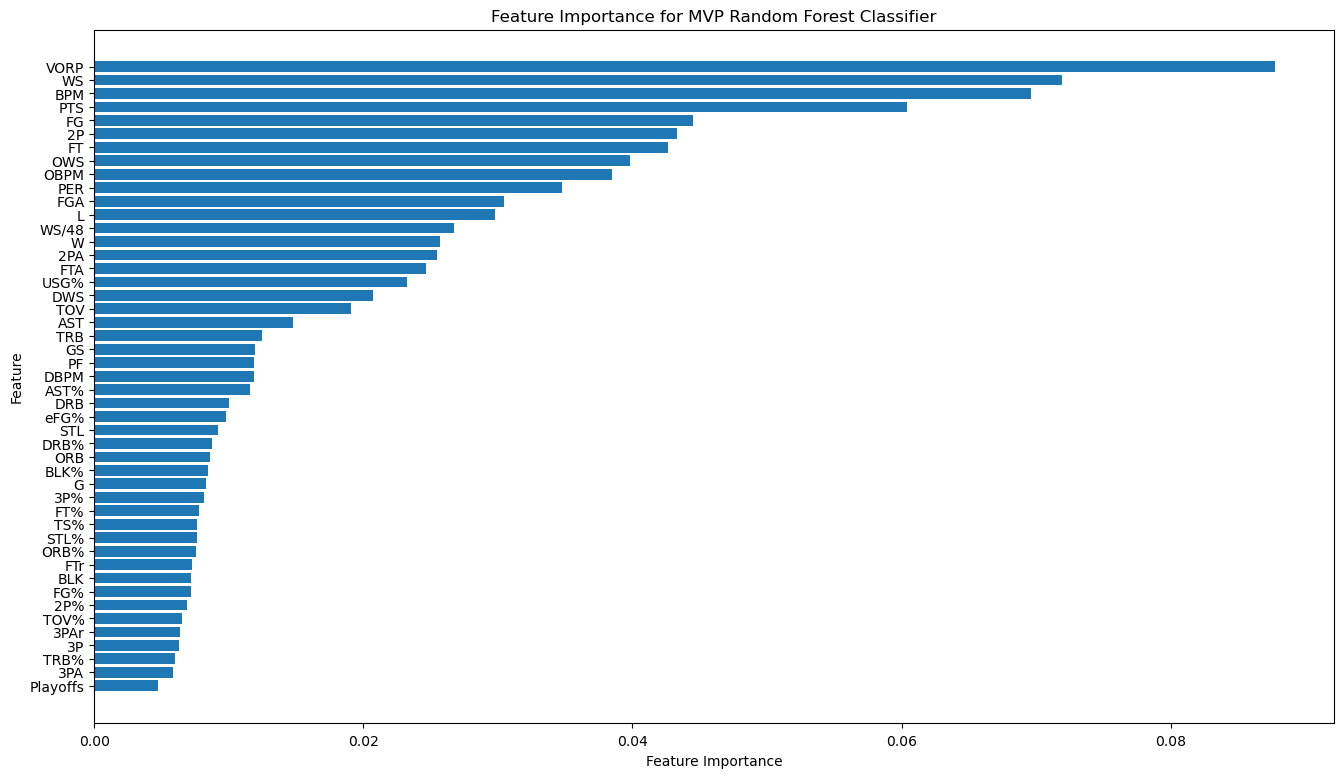

In [63]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(list(mvp_feat_imp.keys()),list(mvp_feat_imp.values()))
ax.xaxis.set_tick_params(pad = 5)
ax.set_title('Feature Importance for MVP Random Forest Classifier')
ax.set_ylabel('Feature')
ax.set_xlabel('Feature Importance')

fig.savefig('MVP_Feature_Importance.png')

#### DPOY

In [21]:
print(f'The training accuracy: {dpoy_clf.score(Xd_train,yd_train)}')
print(f'The out of bag classification accuracy: {dpoy_clf.oob_score_}')

The training accuracy: 0.9993442008619075
The out of bag classification accuracy: 0.9728311785647368


In [22]:
dpoy_clf.score(Xd_test,yd_test)

0.9730185497470489

In [23]:
dpoy_clf.feature_importances_

array([0.00294635, 0.1341138 , 0.06697427, 0.02988625, 0.07303535,
       0.0486685 , 0.03075727, 0.04298797, 0.03169611, 0.03241494,
       0.04350719, 0.03483611, 0.03748431, 0.05784442, 0.08361361,
       0.02879641, 0.03487384, 0.0404087 , 0.03103309, 0.03018462,
       0.04209223, 0.04184466])

In [24]:
for i in range(20,100,5):
    dpoy_clf = RandomForestClassifier(i, oob_score = True).fit(Xd_train,yd_train)
    print(f'Test Accuracy with {i} trees = {dpoy_clf.score(Xd_test,yd_test)}')

/Users/claykindiger/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Test Accuracy with 20 trees = 0.9738617200674536
Test Accuracy with 25 trees = 0.9738617200674536
Test Accuracy with 30 trees = 0.9738617200674536
Test Accuracy with 35 trees = 0.9730185497470489
Test Accuracy with 40 trees = 0.96964586846543
Test Accuracy with 45 trees = 0.9704890387858347
Test Accuracy with 50 trees = 0.9713322091062394
Test Accuracy with 55 trees = 0.9721753794266442
Test Accuracy with 60 trees = 0.9721753794266442
Test Accuracy with 65 trees = 0.9738617200674536
Test Accuracy with 70 trees = 0.9721753794266442
Test Accuracy with 75 trees = 0.9721753794266442
Test Accuracy with 80 trees = 0.9713322091062394
Test Accuracy with 85 trees = 0.9738617200674536
Test Accuracy with 90 trees = 0.9721753794266442
Test Accuracy with 95 trees = 0.9738617200674536


In [58]:
i = 0
dpoy_feat_imp = {}
cols = list(dpoy_dataset.columns)
for val in dpoy_clf.feature_importances_:
    if cols[i] == 'received_dpoy_votes':
        i += 1
        pass
    dpoy_feat_imp[cols[i].split('_')[0]] = val
    print(f'The imporance of {cols[i]} = {val}')
    i += 1

The imporance of Playoffs = 0.003553895338731497
The imporance of DWS = 0.12298514758466447
The imporance of WS = 0.05390864466759339
The imporance of WS/48 = 0.027807888965795613
The imporance of DBPM = 0.07876874118077534
The imporance of VORP = 0.05610686887787355
The imporance of G_normalized = 0.03226922386203997
The imporance of GS_normalized = 0.038418668958843605
The imporance of W_normalized = 0.030918916933481953
The imporance of L_normalized = 0.032582639780144876
The imporance of ORB_normalized = 0.03625893698179234
The imporance of DRB_normalized = 0.038442922070922626
The imporance of TRB_normalized = 0.03802227997103456
The imporance of STL_normalized = 0.05493028580032768
The imporance of BLK_normalized = 0.09820507633763516
The imporance of PF_normalized = 0.031240704077603917
The imporance of PTS_normalized = 0.034458819971404875
The imporance of PER_normalized = 0.04020699202333306
The imporance of DRB%_normalized = 0.03296590389263629
The imporance of TRB%_normalize

In [60]:
dpoy_feat_imp = {k: v for k, v in sorted(dpoy_feat_imp.items(), key=lambda item: item[1])}

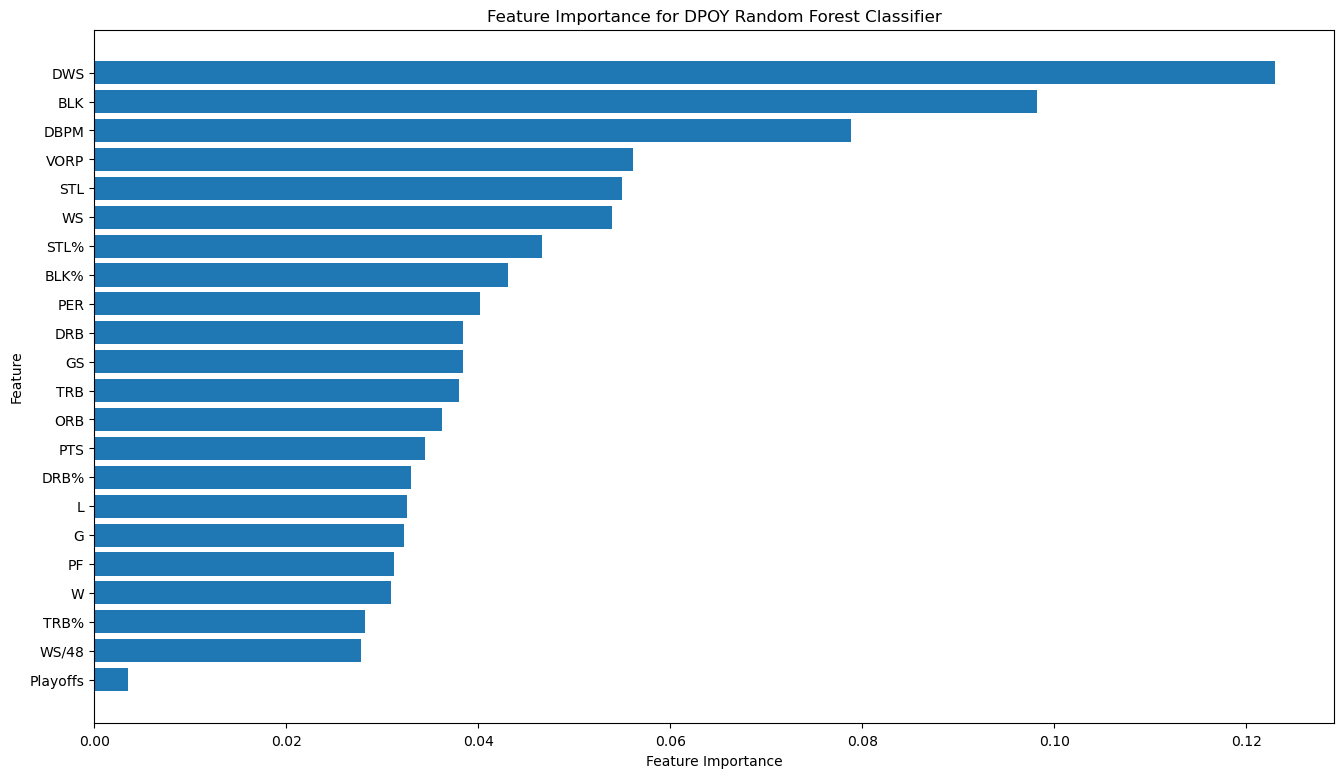

In [62]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(list(dpoy_feat_imp.keys()),list(dpoy_feat_imp.values()))
ax.xaxis.set_tick_params(pad = 5)
ax.set_title('Feature Importance for DPOY Random Forest Classifier')
ax.set_ylabel('Feature')
ax.set_xlabel('Feature Importance')

fig.savefig('DPOY_Feature_Importance.png')

### Regression (voting share)

#### MVP

In [78]:
# Predictions for regression
ym_pred_regr = mvp_regr_pipe.predict(Xmp_test_regr)

# Regression metrics
mse_mvp_regr = mean_squared_error(ymp_test_regr, ym_pred_regr)
mae_mvp_regr = mean_absolute_error(ymp_test_regr, ym_pred_regr)
r2_mvp_regr = r2_score(ymp_test_regr, ym_pred_regr)

print("Mean Squared Error (MSE) for Regression:", mse_mvp_regr)
print("Mean Absolute Error (MAE) for Regression:", mae_mvp_regr)
print("R² Score for Regression:", r2_mvp_regr)

Mean Squared Error (MSE) for Regression: 0.030013015672222216
Mean Absolute Error (MAE) for Regression: 0.11649305555555554
R² Score for Regression: 0.5929635169025568


In [79]:
# Predictions for regression
ym_pred_regr = mvp_regr_full.predict(Xmf_test_regr)

# Regression metrics
mse_mvp_regr = mean_squared_error(ymf_test_regr, ym_pred_regr)
mae_mvp_regr = mean_absolute_error(ymf_test_regr, ym_pred_regr)
r2_mvp_regr = r2_score(ymf_test_regr, ym_pred_regr)

print("Mean Squared Error (MSE) for Regression:", mse_mvp_regr)
print("Mean Absolute Error (MAE) for Regression:", mae_mvp_regr)
print("R² Score for Regression:", r2_mvp_regr)

Mean Squared Error (MSE) for Regression: 0.0012223981993254639
Mean Absolute Error (MAE) for Regression: 0.003987521079258011
R² Score for Regression: 0.4929331967209628


In [83]:
for i in range(20,80,5):
    mvp_regr = RandomForestRegressor(i, oob_score = True).fit(Xmp_train_regr,ymp_train_regr)
    print(f'Piped R² Score with {i} trees = {mvp_regr.score(Xmp_test_regr,ymp_test_regr)}')
    
    mvp_regr = RandomForestRegressor(i, oob_score = True).fit(Xmf_train_regr,ymf_train_regr)
    print(f'Full R² Score with {i} trees = {mvp_regr.score(Xmf_test_regr,ymf_test_regr)}')

Piped R² Score with 20 trees = 0.6149432766783276


/Users/claykindiger/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Full R² Score with 20 trees = 0.4528179375588338
Piped R² Score with 25 trees = 0.6524130182924262
Full R² Score with 25 trees = 0.44786632039792373
Piped R² Score with 30 trees = 0.6256066282594908
Full R² Score with 30 trees = 0.46619659175613193
Piped R² Score with 35 trees = 0.6055921622470115
Full R² Score with 35 trees = 0.48006234236247347
Piped R² Score with 40 trees = 0.6177244793346166
Full R² Score with 40 trees = 0.4732854763214548
Piped R² Score with 45 trees = 0.6242327187372427
Full R² Score with 45 trees = 0.4724932436938656
Piped R² Score with 50 trees = 0.5684460295035216
Full R² Score with 50 trees = 0.5017808529994294
Piped R² Score with 55 trees = 0.5993921648358214
Full R² Score with 55 trees = 0.4694260279299115
Piped R² Score with 60 trees = 0.6008231896785237
Full R² Score with 60 trees = 0.4593525010918379
Piped R² Score with 65 trees = 0.5843125170279058
Full R² Score with 65 trees = 0.4718845107750457
Piped R² Score with 70 trees = 0.5990186707606773



KeyboardInterrupt



#### DPOY

In [80]:
# Predictions for regression
yd_pred_regr = dpoy_regr_pipe.predict(Xdp_test_regr)

# Regression metrics
mse_dpoy_regr = mean_squared_error(ydp_test_regr, yd_pred_regr)
mae_dpoy_regr = mean_absolute_error(ydp_test_regr, yd_pred_regr)
r2_dpoy_regr = r2_score(ydp_test_regr, yd_pred_regr)

print("Mean Squared Error (MSE) for Regression:", mse_dpoy_regr)
print("Mean Absolute Error (MAE) for Regression:", mae_dpoy_regr)
print("R² Score for Regression:", r2_dpoy_regr)

Mean Squared Error (MSE) for Regression: 0.026783425733333335
Mean Absolute Error (MAE) for Regression: 0.10772205128205127
R² Score for Regression: -0.09719059072987202


In [81]:
# Predictions for regression
yd_pred_regr = dpoy_regr_full.predict(Xdf_test_regr)

# Regression metrics
mse_dpoy_regr = mean_squared_error(ydf_test_regr, yd_pred_regr)
mae_dpoy_regr = mean_absolute_error(ydf_test_regr, yd_pred_regr)
r2_dpoy_regr = r2_score(ydf_test_regr, yd_pred_regr)

print("Mean Squared Error (MSE) for Regression:", mse_dpoy_regr)
print("Mean Absolute Error (MAE) for Regression:", mae_dpoy_regr)
print("R² Score for Regression:", r2_dpoy_regr)

Mean Squared Error (MSE) for Regression: 0.0009950350025295111
Mean Absolute Error (MAE) for Regression: 0.0034695699831365934
R² Score for Regression: 0.29307709424311723


In [82]:
for i in range(20,80,5):
    dpoy_regr = RandomForestRegressor(i, oob_score = True).fit(Xdp_train_regr,ydp_train_regr)
    print(f'Piped R² Score with {i} trees = {dpoy_regr.score(Xdp_test_regr,ydp_test_regr)}')
    dpoy_regr = RandomForestRegressor(i, oob_score = True).fit(Xdf_train_regr,ydf_train_regr)
    print(f'Full R² Score with {i} trees = {dpoy_regr.score(Xdf_test_regr,ydf_test_regr)}')

Piped R² Score with 20 trees = -0.25249427273844516


/Users/claykindiger/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Full R² Score with 20 trees = 0.2646643454405234
Piped R² Score with 25 trees = -0.20232997247623263
Full R² Score with 25 trees = 0.22536822446522142
Piped R² Score with 30 trees = -0.200214880411137
Full R² Score with 30 trees = 0.3226087301352786
Piped R² Score with 35 trees = -0.2864246245633364
Full R² Score with 35 trees = 0.2835814347579564
Piped R² Score with 40 trees = -0.2499598561024441
Full R² Score with 40 trees = 0.3143773599759192
Piped R² Score with 45 trees = -0.25026236933984514
Full R² Score with 45 trees = 0.31646667032512343
Piped R² Score with 50 trees = -0.09296967721808658
Full R² Score with 50 trees = 0.25256986967740447
Piped R² Score with 55 trees = -0.19813401152109744
Full R² Score with 55 trees = 0.31696536393878383
Piped R² Score with 60 trees = -0.191685718440598
Full R² Score with 60 trees = 0.272056805091188
Piped R² Score with 65 trees = -0.22311168843667328
Full R² Score with 65 trees = 0.29973250516541794
Piped R² Score with 70 trees = -0.2667167144